# Preparing the Big Five Data

> This is one of a series of Jupyter notebooks that provide the code I used in my preparation of *Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions*, University of Chicago Press, 2023.

Before you read these notebooks, please keep in mind:

* Many of the examples will not make sense unless you have read the corresponding chapter in the book.

* In the process of preparing these notebooks, I've made some changes to improve the readability of the code. Also, some of the result depend on random simulations. For both of these reasons, there might be differences between what appears in the book and what you get when you run this code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/clean_big_five.ipynb).

Credit: This is a modified version of
https://www.kaggle.com/psqrtpsqrt/big-five-personality-test-eda, 

by https://www.kaggle.com/psqrtpsqrt

which is under the 

https://www.apache.org/licenses/LICENSE-2.0

This version is copyright Allen Downey, under the same Apache license.

According to Wikipedia, 
> In psychological trait theory, the Big Five personality traits, also known as the five-factor model (FFM) and the OCEAN model, is a suggested taxonomy, or grouping, for personality traits.
>
> The theory identifies five factors:
>
> * openness to experience (inventive/curious vs. consistent/cautious)
> * conscientiousness (efficient/organized vs. extravagant/careless)
> * extraversion (outgoing/energetic vs. solitary/reserved)
> * agreeableness (friendly/compassionate vs. challenging/callous)
> * neuroticism (sensitive/nervous vs. resilient/confident)


## Dataset

According to the codebook supplied with the dataset:

>This data was collected (2016-2018) through an interactive on-line personality test.
>The personality test was constructed with the "Big-Five Factor Markers" from the IPIP. https://ipip.ori.org/newBigFive5broadKey.htm
Participants were informed that their responses would be recorded and used for research at the beginning of the test, and asked to confirm their consent at the end of the test.

The interactive on-line personality test can be found here: https://openpsychometrics.org/tests/IPIP-BFFM/. The test was presented as a single web page, containing 50 questions (10 per trait) and the user had to rate on a five points scale using radio buttons.

The dataset has 1,015,342 rows. Answers and time spent on each question are provided in the dataset. In addition to this, some user's device information have been collected: 
* timestamp when the survey was started
* device's screen width and height
* location information: country, approximate latitude and approximate longitude.



# Data

Download the data from the [Open-Source Psychometrics Project ](https://openpsychometrics.org/_rawdata/).

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://openpsychometrics.org/_rawdata/IPIP-FFM-data-8Nov2018.zip")

Downloaded IPIP-FFM-data-8Nov2018.zip


In [4]:
!ls -lh "IPIP-FFM-data-8Nov2018.zip"

-rw-rw-r-- 1 downey downey 144M Dec  4 09:58 IPIP-FFM-data-8Nov2018.zip


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from zipfile import ZipFile

with ZipFile('IPIP-FFM-data-8Nov2018.zip') as myzip:
    print(myzip.filelist)
    with myzip.open('IPIP-FFM-data-8Nov2018/data-final.csv') as myfile:
        data = pd.read_csv(myfile, sep = "\t")

[<ZipInfo filename='IPIP-FFM-data-8Nov2018/' filemode='drwxrwxr-x' external_attr=0x8010>, <ZipInfo filename='IPIP-FFM-data-8Nov2018/.directory' filemode='-rw-------' external_attr=0x8020 file_size=60>, <ZipInfo filename='IPIP-FFM-data-8Nov2018/codebook.txt' compress_type=deflate filemode='-rw-rw-r--' external_attr=0x8020 file_size=3951 compress_size=1815>, <ZipInfo filename='IPIP-FFM-data-8Nov2018/data-final.csv' compress_type=deflate filemode='-rw-rw-r--' external_attr=0x8020 file_size=416273844 compress_size=150965367>]


## Dataset information

In [9]:
assert data.shape == (1015341, 110)

In [10]:
data.tail()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
1015336,4.0,2.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,...,2018-11-08 12:04:58,1920.0,1080.0,3.0,160.0,10,2,US,39.9883,-75.2208
1015337,4.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,...,2018-11-08 12:07:18,1920.0,1080.0,3.0,122.0,7,1,US,38.0,-97.0
1015338,4.0,2.0,4.0,3.0,5.0,1.0,4.0,2.0,4.0,4.0,...,2018-11-08 12:07:49,1920.0,1080.0,2.0,135.0,12,6,US,36.1473,-86.777
1015339,2.0,4.0,3.0,4.0,2.0,2.0,1.0,4.0,2.0,4.0,...,2018-11-08 12:08:34,1920.0,1080.0,6.0,212.0,8,1,US,34.1067,-117.8067
1015340,4.0,2.0,4.0,2.0,4.0,1.0,4.0,2.0,4.0,4.0,...,2018-11-08 12:08:45,1920.0,1080.0,3.0,176.0,9,1,US,38.0,-97.0


## Data quality

### Missing values

In [11]:
s = data.isnull().sum()
print(s[s != 0])

EXT1           1783
EXT2           1783
EXT3           1783
EXT4           1783
EXT5           1783
               ... 
screenw        2066
screenh        2066
introelapse    2066
testelapse     1783
country          77
Length: 105, dtype: int64


There are missing values in 105 out of 110 columns. It appears that the missing values come from the same observations.

In [12]:
print(s[s != 0].value_counts())

1783    101
2066      3
77        1
dtype: int64


We can afford to discard these rows because we have more than one million rows in the dataset.

In [13]:
data = data.dropna()

In [14]:
print("Dataset (new) shape:", data.shape)

Dataset (new) shape: (1012050, 110)


In [15]:
s = data.isnull().sum()
print(s[s != 0])

Series([], dtype: int64)


Rows with missing values have been discarded successfully.

Let's pay attention to the type of columns.

### Columns type

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1012050 entries, 0 to 1015340
Columns: 110 entries, EXT1 to long_appx_lots_of_err
dtypes: float64(104), int64(2), object(4)
memory usage: 857.1+ MB


Main columns containing answers (EXT1, etc.) are supposed to be integers since the scale contains 5 steps (from 1 to 5).

Let's figure out if those columns don't contain floating values.

First of all, we're going to create a list of column names containing the answers from the test. Personality traits are labeled as:

* EXT: Extroversion
* EST: Neuroticism
* AGR: Agreeableness
* CSN: Conscientiousness
* OPN: Openness

And each trait is figured out through ten questions each.

In [17]:
personality_traits = ["EXT", "AGR", "CSN", "EST", "OPN"]
answer_columns = [trait + str(number) for trait in personality_traits for number in range(1, 11)]
print(answer_columns)

['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10', 'AGR1', 'AGR2', 'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1', 'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10', 'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10']


Let's see if there's a difference between values represented as integers and as floats.

In [18]:
(data[answer_columns] != data[answer_columns].astype(int)).sum()

EXT1     0
EXT2     0
EXT3     0
EXT4     0
EXT5     0
EXT6     0
EXT7     0
EXT8     0
EXT9     0
EXT10    0
AGR1     0
AGR2     0
AGR3     0
AGR4     0
AGR5     0
AGR6     0
AGR7     0
AGR8     0
AGR9     0
AGR10    0
CSN1     0
CSN2     0
CSN3     0
CSN4     0
CSN5     0
CSN6     0
CSN7     0
CSN8     0
CSN9     0
CSN10    0
EST1     0
EST2     0
EST3     0
EST4     0
EST5     0
EST6     0
EST7     0
EST8     0
EST9     0
EST10    0
OPN1     0
OPN2     0
OPN3     0
OPN4     0
OPN5     0
OPN6     0
OPN7     0
OPN8     0
OPN9     0
OPN10    0
dtype: int64

Values can be converted to integers without any difference. This will save a lot of memory and the EDA will be cleaner later.

In [19]:
data[answer_columns] = data[answer_columns].astype(int)

According to the codebook, given latitudes and longitudes (`lat_appx_lots_of_err` and `long_appx_lots_of_err` columns) are very inaccurate, so both columns will be dropped. User location will be based on countries (`country` column, using the ISO 3166-1 alpha-2 standard).

In [20]:
data.drop(["lat_appx_lots_of_err", "long_appx_lots_of_err"], axis = 1, inplace = True)

### Outliers handling

Let's give a look to answers given to the 50 questions.

In [21]:
data[answer_columns].apply(pd.Series.value_counts)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,3717,6091,6070,6886,9761,6181,8169,6365,6837,6258,...,9184,5936,7578,6657,7675,8120,8460,8018,7682,6171
1,249403,209781,76632,101861,98351,266184,236496,78056,173108,76378,...,43815,379557,23593,413184,16268,467024,15419,103843,19918,16574
2,198907,235137,191497,207888,178281,337682,227487,175505,220978,158031,...,102283,317113,72516,301369,59273,307824,56336,198022,56579,63468
3,288087,244322,268693,279681,234063,191087,194478,229599,214622,191047,...,250908,185837,174200,188717,272565,118668,180758,251759,127869,211764
4,191359,189956,283670,256806,298781,139337,197080,274541,241981,267835,...,331532,88613,313710,68946,395077,73393,401332,286140,343829,342825
5,80577,126763,185488,158928,192813,71579,148340,247984,154524,312501,...,274328,34994,420453,33177,261192,37021,349745,164268,456173,371248


The questions scale goes from 1 to 5. The zero value isn't supposed to exist, it probably means that the question hasn't been answered: the user didn't click on any radio button from the respective row. 

Observations containing at least a "0" from these columns will be discarded.

In [22]:
data = data[(data[answer_columns] != 0).all(axis = 1)]
data.shape

(873173, 108)

## Personality traits analysis

Personality traits score can be obtained by aggregating answers. According to the test documentation, questions can be positive keyed or negative keyed.

| Code  | Question                                                 | Key |    | Code  | Question                                                 | Key |
|-------|:---------------------------------------------------------|-----|----|-------|:---------------------------------------------------------|-----|
| EXT1	| I am the life of the party.                              | (+) | \| | EST1  | I get stressed out easily.                               | (+) |
| EXT2	| I don't talk a lot.                                      | (-) | \| | EST2  | I am relaxed most of the time.                           | (-) |
| EXT3	| I feel comfortable around people.                        | (+) | \| | EST3  | I worry about things.                                    | (+) |
| EXT4	| I keep in the background.                                | (-) | \| | EST4  | I seldom feel blue.                                      | (-) |
| EXT5	| I start conversations.                                   | (+) | \| | EST5  | I am easily disturbed.                                   | (+) |
| EXT6	| I have little to say.                                    | (-) | \| | EST6  | I get upset easily.                                      | (+) |
| EXT7	| I talk to a lot of different people at parties.          | (+) | \| | EST7  | I change my mood a lot.                                  | (+) |
| EXT8	| I don't like to draw attention to myself.                | (-) | \| | EST8  | I have frequent mood swings.                             | (+) |
| EXT9	| I don't mind being the center of attention.              | (+) | \| | EST9  | I get irritated easily.                                  | (+) |
| EXT10	| I am quiet around strangers.                             | (-) | \| | EST10 | I often feel blue.                                       | (+) |


| Code  | Question                                                 | Key |    | Code  | Question                                                 | Key |
|-------|:---------------------------------------------------------|-----|----|-------|:---------------------------------------------------------|-----|
| AGR1	| I feel little concern for others.                        | (-) | \| | CSN1  | I am always prepared.                                    | (+) |
| AGR2	| I am interested in people.                               | (+) | \| | CSN2  | I leave my belongings around.                            | (-) |
| AGR3	| I insult people.                                         | (-) | \| | CSN3  | I pay attention to details.                              | (+) |
| AGR4	| I sympathize with others' feelings.                      | (+) | \| | CSN4  | I make a mess of things.                                 | (-) |
| AGR5	| I am not interested in other people's problems.          | (-) | \| | CSN5  | I get chores done right away.                            | (+) |
| AGR6	| I have a soft heart.                                     | (+) | \| | CSN6  | I often forget to put things back in their proper place. | (-) |
| AGR7	| I am not really interested in others.                    | (-) | \| | CSN7  | I like order.                                            | (+) |
| AGR8	| I take time out for others.                              | (+) | \| | CSN8  | I shirk my duties.                                       | (-) |
| AGR9	| I feel others' emotions.                                 | (+) | \| | CSN9  | I follow a schedule.                                     | (+) |
| AGR10	| I make people feel at ease.                              | (+) | \| | CSN10 | I am exacting in my work.                                | (+) |


| Code  | Question                                              | Key |
|-------|:---------------------------------------------------------|-----|
| OPN1	| I have a rich vocabulary.                                | (+) |
| OPN2	| I have difficulty understanding abstract ideas.          | (-) |
| OPN3	| I have a vivid imagination.                              | (+) |
| OPN4	| I am not interested in abstract ideas.                   | (-) |
| OPN5	| I have excellent ideas.                                  | (+) |
| OPN6	| I do not have a good imagination.                        | (-) |
| OPN7	| I am quick to understand things.                         | (+) |
| OPN8	| I use difficult words.                                   | (-) |
| OPN9	| I spend time reflecting on things.                       | (+) |
| OPN10	| I am full of ideas.                                      | (+) |

First, let's rescale values (1, ..., 5) to (-2, ..., 2). So we can compare traits scores together.

In [23]:
data[answer_columns] = data[answer_columns].apply(lambda x: x - 3)

Then, let's aggregate values to get a score for each personality treat, according to positive or negative keys listed in the tables above.

In [24]:
data["EXT"] = data["EXT1"] - data["EXT2"] + data["EXT3"] - data["EXT4"] + \
    data["EXT5"] - data["EXT6"] + data["EXT7"] - data["EXT8"] + data["EXT9"] - data["EXT10"]

data["EST"] = data["EST1"] - data["EST2"] + data["EST3"] - data["EST4"] + \
    data["EST5"] + data["EST6"] + data["EST7"] + data["EST8"] + data["EST9"] + data["EST10"]

# The previous line is coded for neuroticism rather than emotional stability,
# so I'm going to flip it
data["EST"] *= -1

data["AGR"] = - data["AGR1"] + data["AGR2"] - data["AGR3"] + data["AGR4"] - \
    data["AGR5"] + data["AGR6"] - data["AGR7"] + data["AGR8"] + data["AGR9"] + data["AGR10"]

data["CSN"] = data["CSN1"] - data["CSN2"] + data["CSN3"] - data["CSN4"] + \
    data["CSN5"] - data["CSN6"] + data["CSN7"] - data["CSN8"] + data["CSN9"] + data["CSN10"]

data["OPN"] = data["OPN1"] - data["OPN2"] + data["OPN3"] - data["OPN4"] + \
    data["OPN5"] - data["OPN6"] + data["OPN7"] - data["OPN8"] + data["OPN9"] + data["OPN10"]

Write the data to an HDF file.

In [25]:
keepers = personality_traits + answer_columns

In [43]:
if exists('big_five_data.hdf'):
    !rm big_five_data.hdf

In [44]:
data[keepers].to_hdf('big_five_data.hdf', 'big_five', complevel=3)

In [45]:
!ls -lh big_five_data.hdf

-rw-rw-r-- 1 downey downey 82M Dec  4 10:05 big_five_data.hdf


## Explore the data

We can plot the score distributions for each personality trait.

/home/downey/anaconda3/envs/ProbablyOverthinkingIt/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


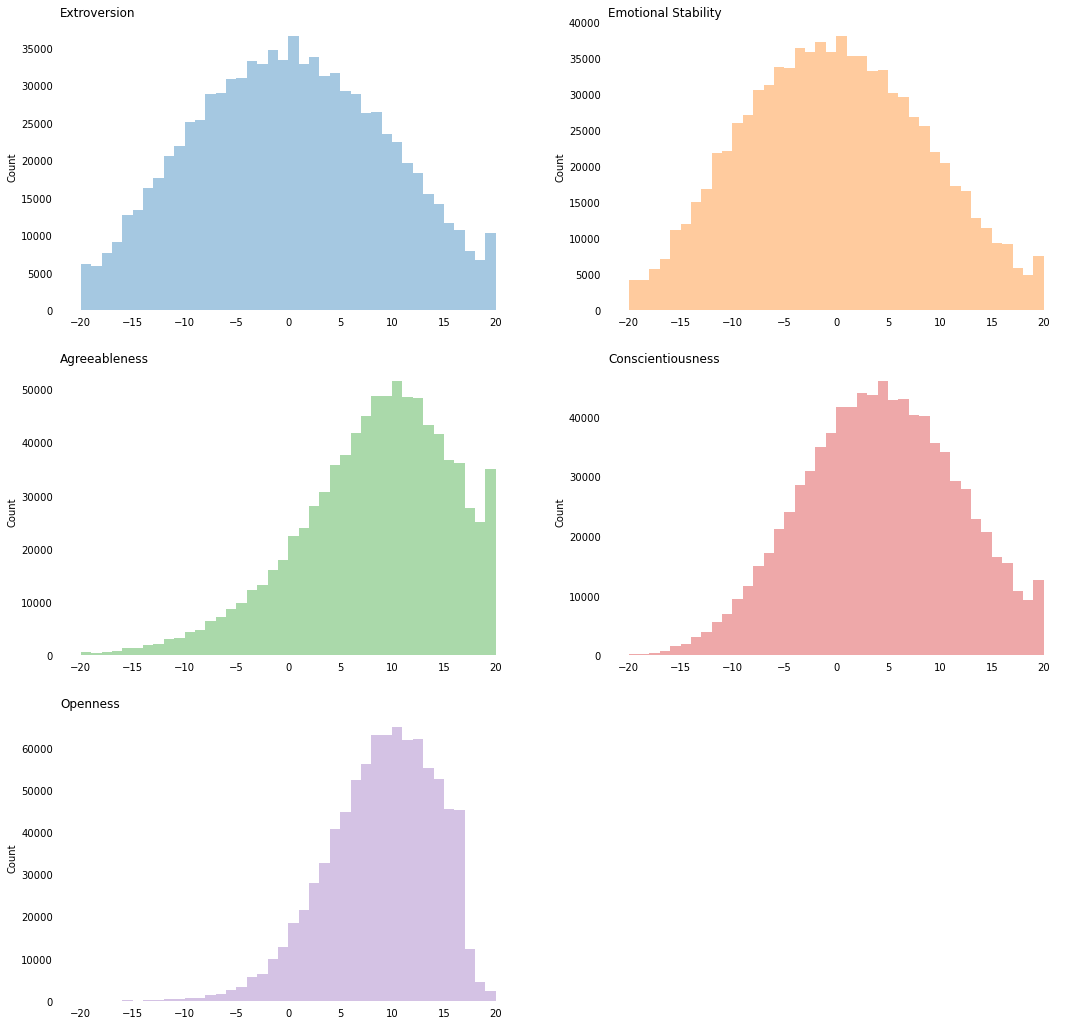

In [27]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (18, 18))
sns.distplot(data["EXT"], bins = 40, kde = False, 
             ax = axs[0, 0], color = sns.color_palette()[0]).set_title("Extroversion")
sns.distplot(data["EST"], bins = 40, kde = False, 
             ax = axs[0, 1], color = sns.color_palette()[1]).set_title("Emotional Stability")
sns.distplot(data["AGR"], bins = 40, kde = False, 
             ax = axs[1, 0], color = sns.color_palette()[2]).set_title("Agreeableness")
sns.distplot(data["CSN"], bins = 40, kde = False, 
             ax = axs[1, 1], color = sns.color_palette()[3]).set_title("Conscientiousness")
sns.distplot(data["OPN"], bins = 40, kde = False, 
             ax = axs[2, 0], color = sns.color_palette()[4]).set_title("Openness")

fig.delaxes(axs[2, 1])
for ax in axs.flat:
    ax.set(xlabel = None, ylabel = "Count")
    
plt.show()

### Correlations

Are personality traits correlated?

In [28]:
correlation = data[personality_traits].corr()
print(correlation)

          EXT       AGR       CSN       EST       OPN
EXT  1.000000  0.299514  0.064120  0.221992  0.168207
AGR  0.299514  1.000000  0.144652  0.041111  0.167185
CSN  0.064120  0.144652  1.000000  0.231900  0.092478
EST  0.221992  0.041111  0.231900  1.000000  0.116786
OPN  0.168207  0.167185  0.092478  0.116786  1.000000


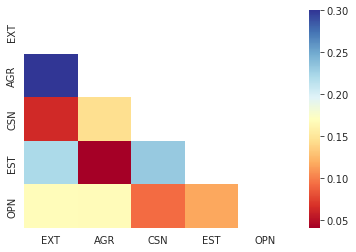

In [29]:
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(correlation, mask = mask, vmax = .3, cmap = "RdYlBu")
plt.show()

Extroversion and Agreeableness go in the same direction (+0.30). However, Neuroticism has a negative correlation with Extroversion and Conscientiousness (-0.22 and -0.23).

### Values pattern

Do some questions have specific patterns (mostly extreme values? neutral? ...)?

In [30]:
df_answers = pd.melt(data[answer_columns])
df_answers["trait"] = df_answers["variable"].str.slice(0, 3)
df_answers = df_answers.groupby(["variable", "value"]).count()
df_answers.reset_index(inplace = True)
df_answers = df_answers.rename(columns = {"trait": "count"})
df_answers["trait"] = df_answers["variable"].str.slice(0, 3)

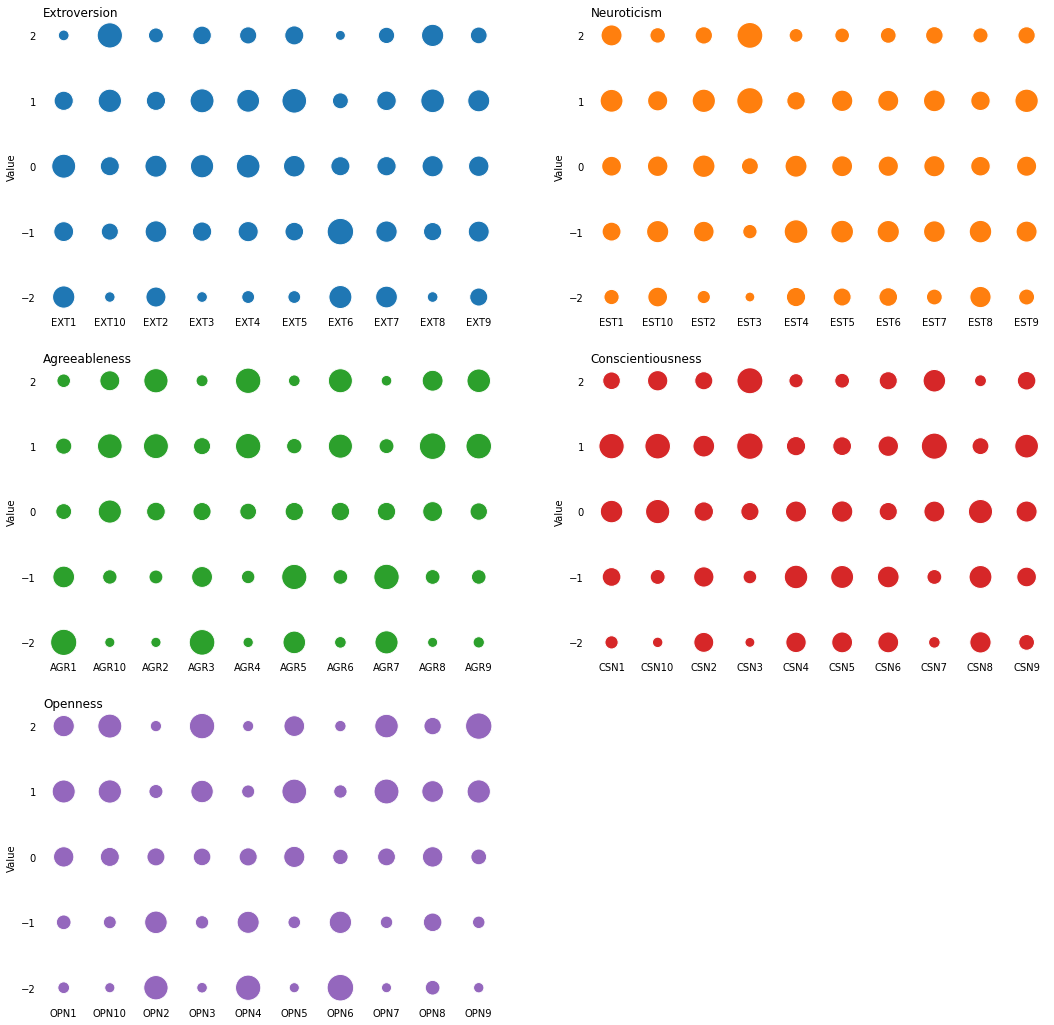

In [31]:
fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (18, 18))

sns.scatterplot(x = "variable", y = "value", size = "count", 
                color = sns.color_palette()[0], data = df_answers[df_answers["trait"] == "EXT"], 
                sizes = (100, 700), ax = axs[0, 0], legend = None).set_title("Extroversion")

sns.scatterplot(x = "variable", y = "value", size = "count", 
                color = sns.color_palette()[1], data = df_answers[df_answers["trait"] == "EST"], 
                sizes = (100, 700), ax = axs[0, 1], legend = None).set_title("Neuroticism")

sns.scatterplot(x = "variable", y = "value", size = "count", 
                color = sns.color_palette()[2], data = df_answers[df_answers["trait"] == "AGR"], 
                sizes = (100, 700), ax = axs[1, 0], legend = None).set_title("Agreeableness")

sns.scatterplot(x = "variable", y = "value", size = "count", 
                color = sns.color_palette()[3], data = df_answers[df_answers["trait"] == "CSN"], 
                sizes = (100, 700), ax = axs[1, 1], legend = None).set_title("Conscientiousness")

sns.scatterplot(x = "variable", y = "value", size = "count", 
                color = sns.color_palette()[4], data = df_answers[df_answers["trait"] == "OPN"], 
                sizes = (100, 700), ax = axs[2, 0], legend = None).set_title("Openness")

fig.delaxes(axs[2, 1])

for ax in axs.flat:
    ax.set(xlabel = None, ylabel = "Value")

plt.setp(axs, yticks = range(-2, 3))
plt.show()

Regarding Agreeableness and Openness traits, people are able to feel concerned about the questions: they barely stay neutral and prefer ticking extreme values on the scale. Both traits had a distribution following some left-skewed Gaussian curve. The trend is more noisy for the other traits.